In [1]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
from cadet import Cadet
from addict import Dict
import json
from pathlib import Path

In [2]:
# macOS installation path
Cadet.cadet_path = '/users/hoangnguyen/cadet-core/cadet/bin/cadet-cli'

In [3]:
# Windows installation path
# Cadet.cadet_path = 'C:/Users/hoang/miniconda3/envs/cadet-env/bin/cadet-cli.exe'

In [4]:
base_dir = Path('./').absolute()

match_config = Dict()
match_config.CADETPath = Cadet.cadet_path
match_config.baseDir = base_dir.as_posix()
match_config.resultsDir = 'results'

In [5]:
def get_cadet_template(n_units=3, split_components_data=False):
    cadet_template = Cadet()
    
    cadet_template.root.input.model.nunits = n_units
    
    # Store solution
    cadet_template.root.input['return'].split_components_data = split_components_data
    cadet_template.root.input['return'].split_ports_data = 0
    cadet_template.root.input['return'].unit_000.write_solution_inlet = 1
    cadet_template.root.input['return'].unit_000.write_solution_outlet = 1
    cadet_template.root.input['return'].unit_000.write_solution_bulk = 1
    cadet_template.root.input['return'].unit_000.write_solution_particle = 1
    cadet_template.root.input['return'].unit_000.write_solution_solid = 1
    cadet_template.root.input['return'].unit_000.write_solution_flux = 1
    cadet_template.root.input['return'].unit_000.write_solution_volume = 1
    cadet_template.root.input['return'].unit_000.write_coordinates = 1
    cadet_template.root.input['return'].unit_000.write_sens_outlet = 1
    
    for unit in range(n_units):
        cadet_template.root.input['return']['unit_{0:03d}'.format(unit)] = cadet_template.root.input['return'].unit_000
        
    # Tolerances for the time integrator
    cadet_template.root.input.solver.time_integrator.abstol = 1e-6
    cadet_template.root.input.solver.time_integrator.algtol = 1e-10
    cadet_template.root.input.solver.time_integrator.reltol = 1e-6
    cadet_template.root.input.solver.time_integrator.init_step_size = 1e-6
    cadet_template.root.input.solver.time_integrator.max_steps = 1000000
    
    # Solver settings
    cadet_template.root.input.model.solver.gs_type = 1
    cadet_template.root.input.model.solver.max_krylov = 0
    cadet_template.root.input.model.solver.max_restarts = 10
    cadet_template.root.input.model.solver.schur_safety = 1e-8

    # Run the simulation on single thread
    cadet_template.root.input.solver.nthreads = 1
    
    return cadet_template

In [6]:
def set_discretization(model, n_bound=None, n_col=20, n_par_types=1):
    columns = {'GENERAL_RATE_MODEL', 'LUMPED_RATE_MODEL_WITH_PORES', 'LUMPED_RATE_MODEL_WITHOUT_PORES'}
    
    
    for unit_name, unit in model.root.input.model.items():
        if 'unit_' in unit_name and unit.unit_type in columns:
            unit.discretization.ncol = n_col
            unit.discretization.npar = 5
            unit.discretization.npartype = n_par_types
            
            if n_bound is None:
                n_bound = unit.ncomp*[0]
            unit.discretization.nbound = n_bound
            
            unit.discretization.par_disc_type = 'EQUIDISTANT_PAR'
            unit.discretization.use_analytic_jacobian = 1
            unit.discretization.reconstruction = 'WENO'
            unit.discretization.gs_type = 1
            unit.discretization.max_krylov = 0
            unit.discretization.max_restarts = 10
            unit.discretization.schur_safety = 1.0e-8

            unit.discretization.weno.boundary_model = 0
            unit.discretization.weno.weno_eps = 1e-10
            unit.discretization.weno.weno_order = 3

In [7]:
# Auxiliary variables
t_cycle = 100

init_c = [1.0, 0.0]
V = 1e-6

kfwd = [0.1]
kbwd = [0.0]

stoich = [-1, 
           1]

In [8]:
model = get_cadet_template(n_units=1)

n_comp = len(init_c)

# CSTR
model.root.input.model.unit_000.unit_type = 'CSTR'
model.root.input.model.unit_000.ncomp = n_comp
model.root.input.model.unit_000.init_volume = V
model.root.input.model.unit_000.init_c = init_c

# Reaction
model.root.input.model.unit_000.reaction_model = 'MASS_ACTION_LAW'
model.root.input.model.unit_000.reaction_bulk.mal_kfwd_bulk = kfwd
model.root.input.model.unit_000.reaction_bulk.mal_kbwd_bulk = kbwd
model.root.input.model.unit_000.reaction_bulk.mal_stoichiometry_bulk = stoich 

# Sections and Switches
model.root.input.solver.sections.nsec = 1
model.root.input.solver.sections.section_times = [0.0, t_cycle]
model.root.input.solver.user_solution_times = np.linspace(0, t_cycle, 1001)

model.root.input.model.connections.nswitches = 1
model.root.input.model.connections.switch_000.section = 0
model.root.input.model.connections.switch_000.connections = []

In [9]:
def run_simulation(cadet, file_name=None):
    if file_name is None:
        f = next(tempfile._get_candidate_names())
        cadet.filename = os.path.join(tempfile.tempdir, f + '.h5')
    else:
        cadet.filename = file_name
    # save the simulation
    cadet.save()

    # run the simulation and load results
    data = cadet.run()
    cadet.load()
    
    # Remove files 
    if file_name is None:
        os.remove(os.path.join(tempfile.tempdir, f + '.h5'))

    # Raise error if simulation fails
    if data.returncode == 0:
        print("Simulation completed successfully")
    else:
        print(data)
        raise Exception("Simulation failed")

In [10]:
run_simulation(model, 'forward-reaction.h5')

Simulation completed successfully


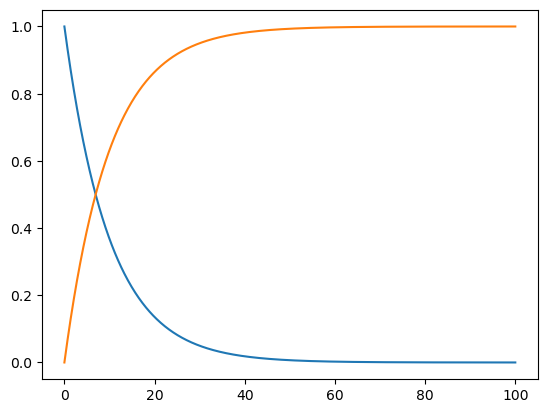

In [11]:
time = model.root.output.solution.solution_times
solution_bulk = model.root.output.solution.unit_000.solution_bulk
plt.plot(time, solution_bulk)

In [34]:
solution_bulk[:,0]

array([1.00000000e+00, 9.90049788e-01, 9.80198310e-01, ...,
       4.71385636e-05, 4.66675559e-05, 4.61996435e-05])

In [35]:
import csv
with open('forward_reaction_exp.csv','w') as f:
    # create the csv writer
    writer = csv.writer(f)

    # write a column to the csv file
    writer.writerow(time)
    writer.writerow(solution_bulk[:,0])
    writer.writerow(solution_bulk[:,1])

In [12]:
parameter1 = Dict()
parameter1.location = '/input/model/unit_000/reaction_bulk/mal_kfwd_bulk'
parameter1.min = 0
parameter1.max = 1
parameter1.component = -1
parameter1.bound = -1
parameter1.transform = 'null'

match_config.parameters = [parameter1, ]

In [37]:
experiment1 = Dict()
experiment1.name = 'forward_reaction'
experiment1.csv = '../resources/forward_reaction_exp.csv'
experiment1.HDF5 = 'forward-reaction.h5'
experiment1.output_path = '/output/solution/unit_000/SOLUTION_BULK'

match_config.experiments = [experiment1,]

In [38]:
feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'SSE'

experiment1.features = [feature1,]

In [39]:
match_config.searchMethod = 'NSGA3'
match_config.population = 12
match_config.stallGenerations = 10
match_config.finalGradRefinement = True
match_config.gradVector = True

In [40]:
from CADETMatch.jupyter import Match

match_config_file = base_dir / 'reaction.json'

with open(match_config_file.as_posix(), 'w') as json_file:
    json.dump(match_config.to_dict(), json_file, indent='\t')

match = Match(match_config_file)
match.start_sim()

TypeError: float() argument must be a string or a number, not 'Dict'